<a href="https://colab.research.google.com/github/danaahm/NetworkCovid-19/blob/master/CITS4403_ProjectPart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITS4403 Group Project - COVID19 Dataset

 ## Group Members

 ```
 Dana AhmadiBroujeni 22427581

 Ho Ho Yin           22634764

 Jai Osborne         21959293

 Tim Wise            21957423
 ```

## Library Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
#!pip install python_utils
#from python_utils import utils
#from utils import decorate, savefig
import calendar
import random
import collections
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## File Upload

# Part 1 - Preliminary Processing

In [0]:
patient_info = pd.read_csv('PatientInfo.csv',index_col = 'patient_id',parse_dates=['confirmed_date','released_date','deceased_date'])
patient_route = pd.read_csv('PatientRoute.csv',index_col = 'patient_id',parse_dates = ['date'])
patient_route = patient_route.rename(columns={'province':'R_province','city':'R_city'})
patient = patient_info.join(patient_route,lsuffix='_caller', rsuffix='_other')

#handle the numerical data
num_col = list((patient.select_dtypes(include =['int','float'])).columns)
num_col.remove('latitude')
num_col.remove('longitude')
num_col.remove('infection_order')
num_col.remove('contact_number')
num_col.remove('infected_by')
patient.loc[:,['latitude','longitude','infection_order','contact_number']] = patient.loc[:,['latitude','longitude','infection_order','contact_number']].astype('object')

#handle the categorical data
cat_col = (patient.select_dtypes(include =['object'])).columns
#cat_col.append(['latitude','longitude'])
date_col = list((patient.select_dtypes(include =['datetime'])).columns) #+ ['infected_by']
for col in date_col:
    patient[col] = patient[col].dt.strftime('%m/%d/%Y')
date_col_plus = date_col + ['infected_by']
num_cols_with_missing = [col for col in patient[num_col] if patient[col].isnull().any()]
cat_cols_with_missing = [col for col in patient[cat_col] if patient[col].isnull().any()]
date_cols_with_missing = [col for col in patient[date_col] if patient[col].isnull().any()]
cols_with_missing = [col for col in patient.columns if patient[col].isnull().any()]

#transform the missing value in numeric column into mean value of the column
#the missing value in those columns seem appearing systematic, 
#therefore they will be replace by the mean value
#Hence, each coulmn with , for each column with missing entries 
#in the original dataset, we add a new column that shows the location of the imputed entries
patient_plus_num = patient.loc[:,num_col]

num_imputer = SimpleImputer()
num_patient = pd.DataFrame(num_imputer.fit_transform(patient_plus_num))
num_patient.columns = patient_plus_num.columns
num_patient.index = patient.index

#Transform the missing values in categorical variables into the most frequent value in the column

patient_plus_cat = patient.loc[:,cat_col]
cat_imputer = SimpleImputer(strategy = 'most_frequent')
#add a coulmn to give cateogry to different age.
cat_patient = pd.DataFrame(cat_imputer.fit_transform(patient_plus_cat))
age_group = { '10s':'Child',
              '20s':'Young',
              '30s':'Young',
              '40s':'Middle aged',
              '50s':'Middle aged',
              '60s':'Middle aged',
              '70s':'Elderly',
              '80s':'Elderly',
              '90s':'Elderly',
              '100s':'Elderly'}

#Setting age group, we can give use node's shape to represent different age group.
cat_patient.columns = patient_plus_cat.columns
cat_patient.index = patient.index
cat_patient['Age_group'] = cat_patient['age'].map(age_group)

#Fill the NA cell with Unknown.
#Unknow can be not yet recorded, not yet release or the patients recovered from the disease.
patient_plus = patient.copy()
date_patient = patient_plus[date_col_plus].fillna('Unknown')
date_patient.columns = patient_plus[date_col_plus].columns
date_patient.index = patient.index

patient_full = pd.concat([(pd.concat([date_patient,num_patient],axis=1,sort =False)),cat_patient],axis=1,sort =False)
patient_full = patient_full.loc[~patient_full.index.duplicated(keep = 'last')]

#Then we could select coulmns that are needed to build the network and omit those are not needed.

In [0]:
patient_full.head()

,confirmed_date,released_date,deceased_date,date,infected_by,global_num_caller,birth_year,global_num_other,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,state,R_province,R_city,type,latitude,longitude,Age_group
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,
1000000001,01/23/2020,02/05/2020,Unknown,01/24/2020,Unknown,2.0,1964.0,2.0,male,50s,Korea,Seoul,Gangseo-gu,True,overseas inflow,1,75,2020-01-22,released,Seoul,Jung-gu,hospital,37.5672,127.006,Middle aged
1000000002,01/30/2020,03/02/2020,Unknown,01/30/2020,Unknown,5.0,1987.0,5.0,male,30s,Korea,Seoul,Jungnang-gu,True,overseas inflow,1,31,2020-02-27,released,Seoul,Jungnang-gu,hospital,37.6128,127.098,Young
1000000003,01/30/2020,02/19/2020,Unknown,01/26/2020,2.002e+09,6.0,1964.0,6.0,male,50s,Korea,Seoul,Jongno-gu,True,contact with patient,2,17,2020-02-27,released,Seoul,Jongno-gu,restaurant,37.573,126.979,Middle aged
1000000004,01/30/2020,02/15/2020,Unknown,01/30/2020,Unknown,7.0,1991.0,7.0,male,20s,Korea,Seoul,Mapo-gu,True,overseas inflow,1,9,2020-01-26,released,Seoul,Jungnang-gu,hospital,37.6128,127.098,Young
1000000005,01/31/2020,02/24/2020,Unknown,01/31/2020,1e+09,9.0,1992.0,9.0,female,20s,Korea,Seoul,Seongbuk-gu,True,contact with patient,2,2,2020-02-27,released,Seoul,Jungnang-gu,hospital,37.6128,127.098,Young


# Part 2 - Dataset Analysis

## Function Definition

In [0]:
# Function to divide patients into groups according to their age and gender
def patient_group(df):
    CM = list((df.loc[(df.Age_group == 'Child') & (df.sex == 'male')]).index)
    CF = list((df.loc[(df.Age_group == 'Child') & (df.sex == 'female')]).index)
    YM = list((df.loc[(df.Age_group == 'Young') & (df.sex == 'male')]).index)
    YF = list((df.loc[(df.Age_group == 'Young') & (df.sex == 'female')]).index)
    MM = list((df.loc[(df.Age_group == 'Middle aged') & (df.sex == 'male')]).index)
    MF = list((df.loc[(df.Age_group == 'Middle aged') & (df.sex == 'female')]).index)
    EM = list((df.loc[(df.Age_group == 'Elderly') & (df.sex == 'male')]).index)
    EF = list((df.loc[(df.Age_group == 'Elderly') & (df.sex == 'female')]).index)
  
    return CM, CF, YM, YF, MM, MF, EM, EF

In [0]:
# Function to to pair patients and who infected them
def month_edges(df):
    return dict((df.infected_by)).items()

In [0]:
# Function to to create a non-empty patients list
def empty_cat(patient_list):
    return [p for p in patient_list if p]

In [0]:
# Function to create a list of nodes
def nodes_list(patient_list, not_empty):
    node_list = []
    for index in not_empty:
        node_list += patient_list[index]
    return node_list

In [0]:
# To scale up the node's size
def contact(df, group):
    contact_no = []
    for i in group:
        if df.loc[(i),'contact_number'] <= 0:
            contact_no.append(df.loc[(i),'contact_number']+1*40)
            #increase the scale for nodes
        else:
            contact_no.append(df.loc[(i),'contact_number']+1*40)
    return contact_no

In [0]:
def infect_in_gender(df,patient_full):
  all_patients = list(patient_full.index)
  infected = list((df.infected_by))
  infect_gender = {}
  for infect in infected:
    if infect in all_patients:
      infect_gender[infect] = patient_full.sex[infect]
    
  return infect_gender

In [0]:
def patient_infect_pair(df, patient_full):
  infect_gender = infect_in_gender(df, patient_full)
  d = {}
  infectors_pairs = dict(df.infected_by)
  for patient in infectors_pairs.items():
     d[patient] = (df.loc[patient[0],'sex'])
  
  for i in range(len(d)):
    if list(d.keys())[i][1] in infect_gender:
      d[list(d.keys())[i]] = ((list(d.values()))[i],(infect_gender[list(d.keys())[i][1]]))
  return d 

In [0]:
def gender_between_infection(df, patient_full):
  mm = {}
  ff = {}
  fm = {}
  for patient_gender in list(patient_infect_pair(df, patient_full).items()):
    if len(patient_gender[1])== 2:
      if patient_gender[1][0] == 'male' and patient_gender[1][1] == 'male':
        mm[patient_gender[0][0]] =  patient_gender[0][1]
      elif patient_gender[1][0] == 'female' and patient_gender[1][1] == 'female':
        ff[patient_gender[0][0]] =  patient_gender[0][1]
      else:
        fm[patient_gender[0][0]] =  patient_gender[0][1]
  return list(mm.items()),list(ff.items()),list(fm.items())

In [0]:
def draw_month_graph(data, patient_full):
  np.random.seed(19)

  edges = dict((data.infected_by)).items()

  graph = nx.DiGraph()
  graph.add_edges_from(edges)
  graph.add_nodes_from(data.index)
  pos = nx.random_layout(graph)
  
  colour_map = {
      'Child': 'g',
      'Young': 'y',
      'Middle aged': 'r',
      'Elderly': 'b',
      np.nan: 'k',
  }

  shape_map = {
      'male': 'o',
      'female': 'v',
  }

  edge_map = {
      '': '',
  }


  
  for sex, shape in shape_map.items():
    filtered_data = data[data['sex'] == sex]
    nx.draw_networkx_nodes(graph, pos,
        nodelist = list(filtered_data.index),
        node_color = [colour_map[age] for age in filtered_data.Age_group],
        node_shape = shape,
        node_size = list(filtered_data['contact_number'] + 40)
    )

  mm, ff, fm = gender_between_infection(data, patient_full)

  nx.draw_networkx_edges(graph, pos, edgelist=edges)
  nx.draw_networkx_edges(graph, pos, edgelist=mm, edge_color = 'b')
  nx.draw_networkx_edges(graph, pos, edgelist=ff, edge_color = 'r')
  return graph
 


In [0]:
def draw_month_graph(data, patient_full, layout = 'spring'):
  np.random.seed(19)
  CM, CF, YM, YF, MM, MF, EM, EF = patient_group(data)
  patients = CM, CF, YM, YF, MM, MF, EM, EF
  edges = dict((data.infected_by)).items()

  graph = nx.DiGraph()
  graph.add_edges_from(edges)
  graph.add_nodes_from(data.index)

  if layout == 'spring':
    pos = nx.spring_layout(graph)
  else:
    pos = nx.random_layout(graph)
  
  
  all_nodes = set(list(data.index) + list(data.infected_by))
  #Rhombus for female
  nx.draw_networkx_nodes(graph,pos,nodelist= all_nodes,node_color = 'black',node_shape = 'v',node_size = 30,alpha = 0.5)

  nx.draw_networkx_nodes(graph,pos,nodelist = YM, node_color='y',node_shape = 'o',node_size = contact(data,YM)) 
  nx.draw_networkx_nodes(graph,pos,nodelist = YF, node_color = 'y',node_shape = 'd',node_size = contact(data,YF)) 

  nx.draw_networkx_nodes(graph,pos,nodelist = CM, node_color='g',node_shape = 'o',node_size = contact(data,CM)) 
  nx.draw_networkx_nodes(graph,pos,nodelist = CF, node_color = 'g',node_shape = 'd',node_size = contact(data,CF))

  nx.draw_networkx_nodes(graph,pos,nodelist = MM, node_color='r',node_shape = 'o',node_size = contact(data,MM)) 
  nx.draw_networkx_nodes(graph,pos,nodelist = MF, node_color = 'r',node_shape = 'd',node_size = contact(data, MF))

  nx.draw_networkx_nodes(graph,pos,nodelist = EM, node_color='b',node_shape = 'o',node_size = contact(data,EM)) 
  nx.draw_networkx_nodes(graph,pos,nodelist = EF, node_color = 'b',node_shape = 'd',node_size = contact(data,EF))


  mm, ff, fm = gender_between_infection(data, patient_full)

  nx.draw_networkx_edges(graph, pos, edgelist=edges)
  nx.draw_networkx_edges(graph, pos, edgelist=mm, edge_color = 'b')
  nx.draw_networkx_edges(graph, pos, edgelist=ff, edge_color = 'r')
  return graph
 


## Data Processing

In [0]:
g_data = patient_full[patient_full['infected_by']!='Unknown'].copy()

In [0]:
useful_columns = ['Age_group','sex','infected_by','contact_number','confirmed_date','city']
n_data = g_data[useful_columns].copy()
#convert the datatype of confirmed data into datetime format
n_data['confirmed_date'] = pd.to_datetime(n_data['confirmed_date'])

## Visualisation

[link text](https://)

### January Diagram

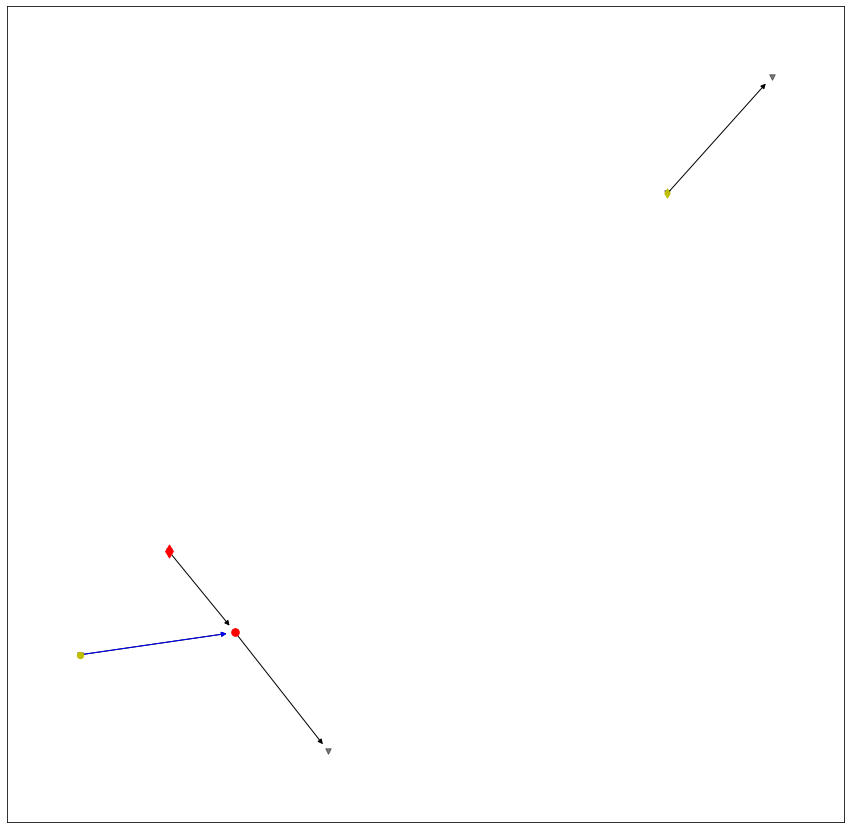

In [0]:
Jan_data = n_data.loc[(n_data['confirmed_date'] >= '2020-01-01') & (n_data['confirmed_date'] < '2020-02-01')]

Jan = draw_month_graph(Jan_data, patient_full)

### February Diagram

<Figure size 4500x4500 with 0 Axes>

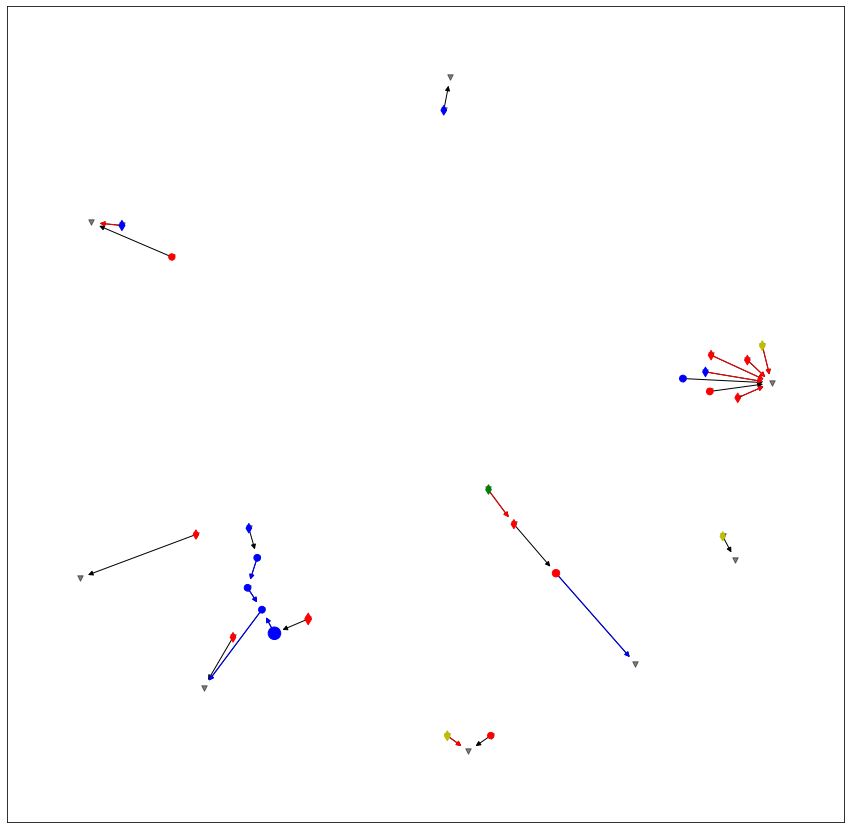

<Figure size 4500x4500 with 0 Axes>

In [0]:
Feb_data_first = n_data.loc[(n_data['confirmed_date'] >= '2020-02-01') & (n_data['confirmed_date'] < '2020-02-21')]
Feb_first = draw_month_graph(Feb_data_first,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

<Figure size 4500x4500 with 0 Axes>

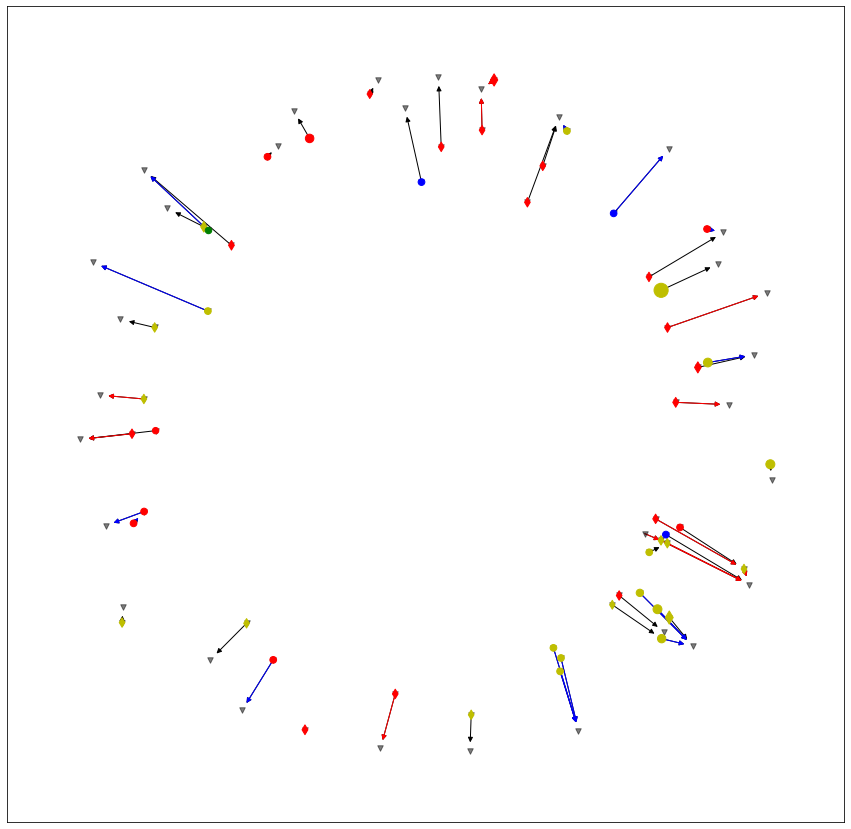

<Figure size 4500x4500 with 0 Axes>

In [0]:
Feb_data_second = n_data.loc[(n_data['confirmed_date'] >= '2020-02-21') & (n_data['confirmed_date'] < '2020-02-26')]
Feb_second = draw_month_graph(Feb_data_second,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

<Figure size 4500x4500 with 0 Axes>

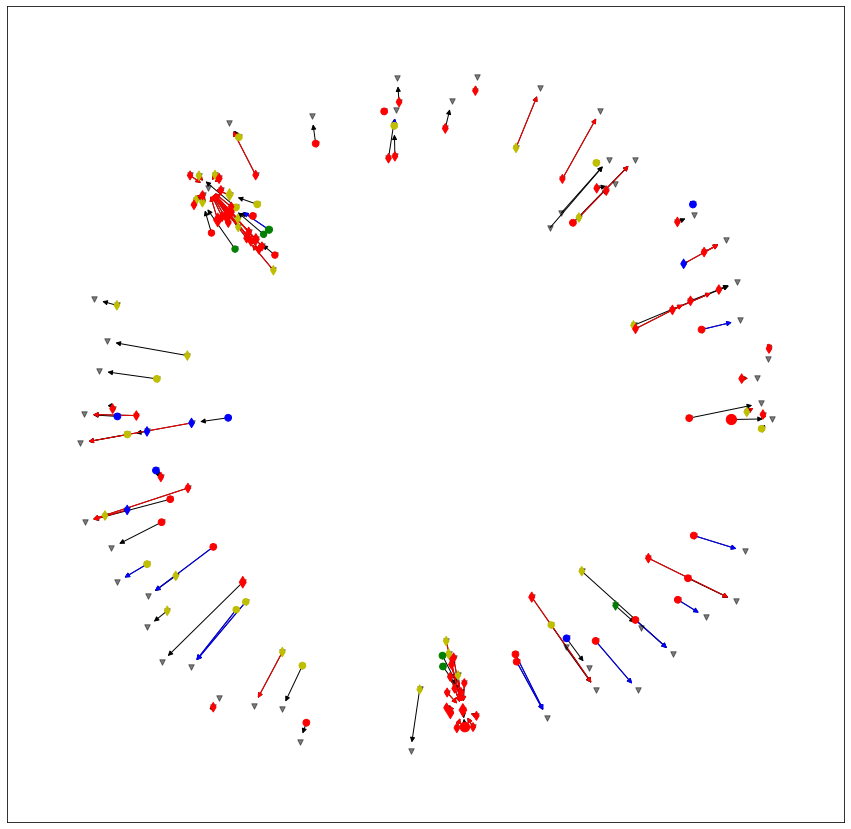

<Figure size 4500x4500 with 0 Axes>

In [0]:
Feb_data_third = n_data.loc[(n_data['confirmed_date'] >= '2020-02-26') & (n_data['confirmed_date'] < '2020-03-01')]
Feb_third = draw_month_graph(Feb_data_third,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

<Figure size 4500x4500 with 0 Axes>

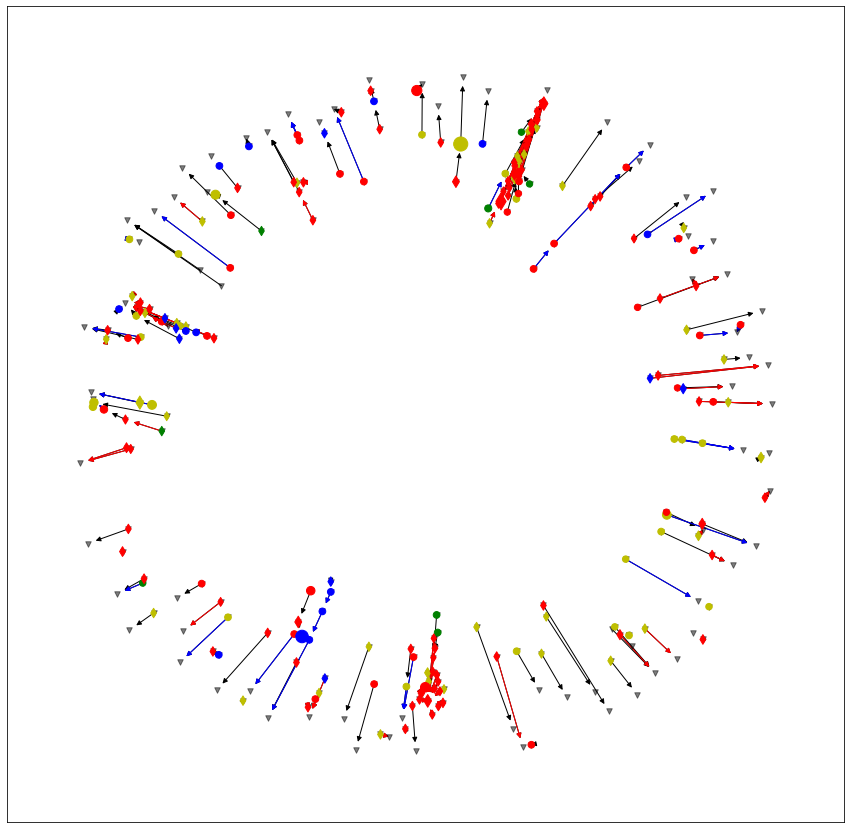

<Figure size 4500x4500 with 0 Axes>

In [0]:
Feb_data_full = n_data.loc[(n_data['confirmed_date'] >= '2020-02-01') & (n_data['confirmed_date'] < '2020-03-01')]
Feb_full = draw_month_graph(Feb_data_full,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

### March Diagram

<Figure size 4500x4500 with 0 Axes>

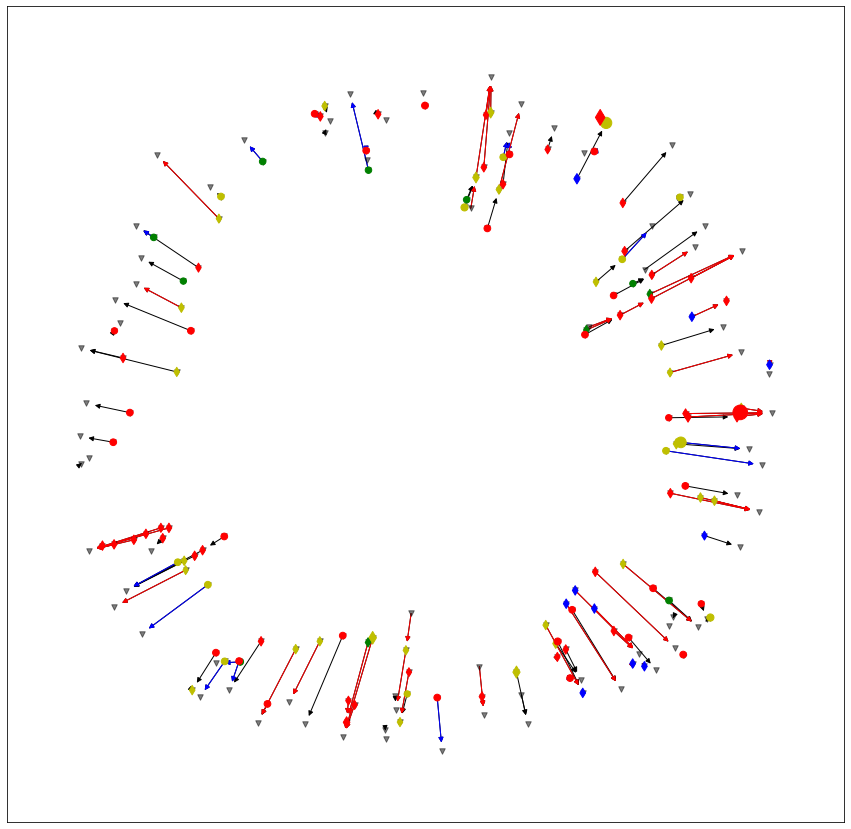

<Figure size 4500x4500 with 0 Axes>

In [0]:
Mar_data_first = n_data.loc[(n_data['confirmed_date'] >= '2020-03-01') & (n_data['confirmed_date'] < '2020-03-10')]
March_first = draw_month_graph(Mar_data_first,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)


<Figure size 4500x4500 with 0 Axes>

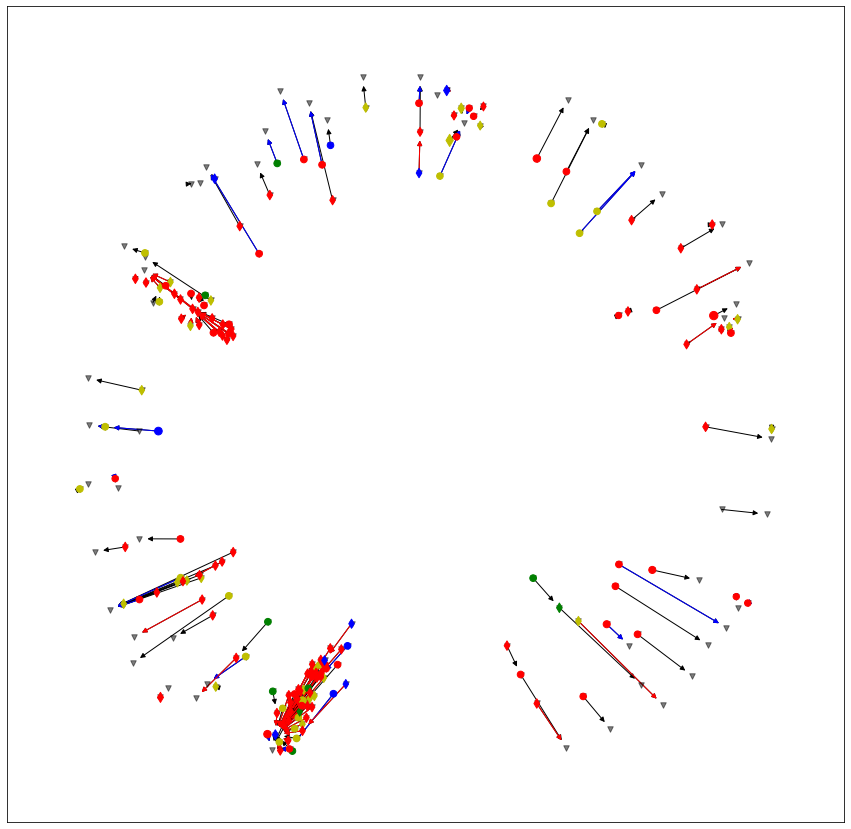

<Figure size 4500x4500 with 0 Axes>

In [0]:
Mar_data_second = n_data.loc[(n_data['confirmed_date'] >= '2020-03-10') & (n_data['confirmed_date'] < '2020-03-21')]
March_second = draw_month_graph(Mar_data_second,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

<Figure size 4500x4500 with 0 Axes>

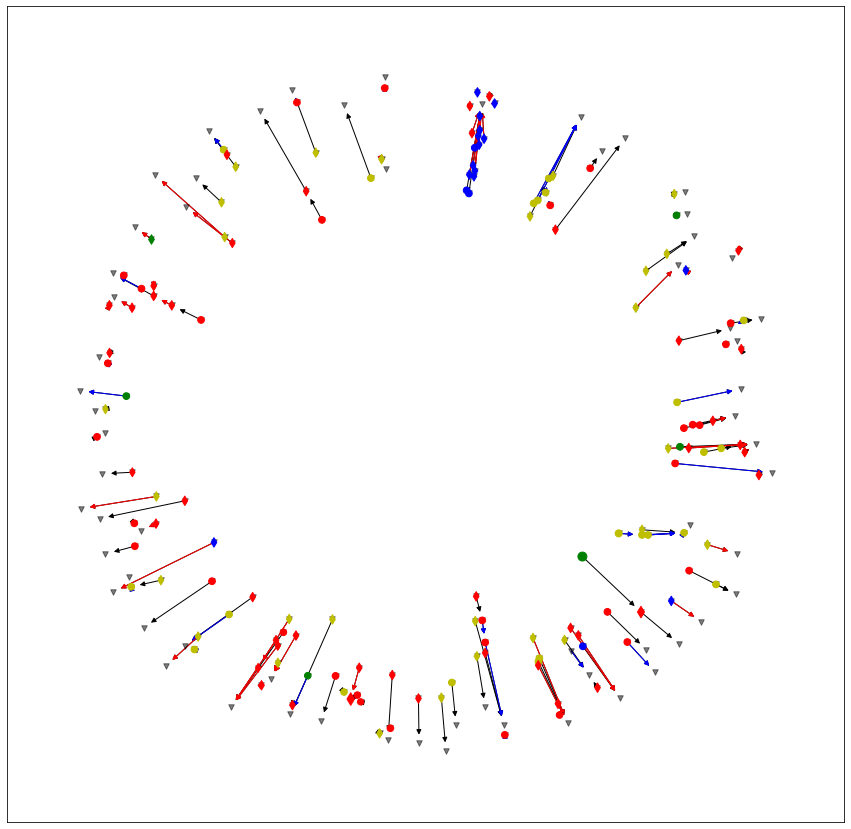

<Figure size 4500x4500 with 0 Axes>

In [0]:
Mar_data_third = n_data.loc[(n_data['confirmed_date'] >= '2020-03-21') & (n_data['confirmed_date'] < '2020-04-01')]
March_third = draw_month_graph(Mar_data_third,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

<Figure size 4500x4500 with 0 Axes>

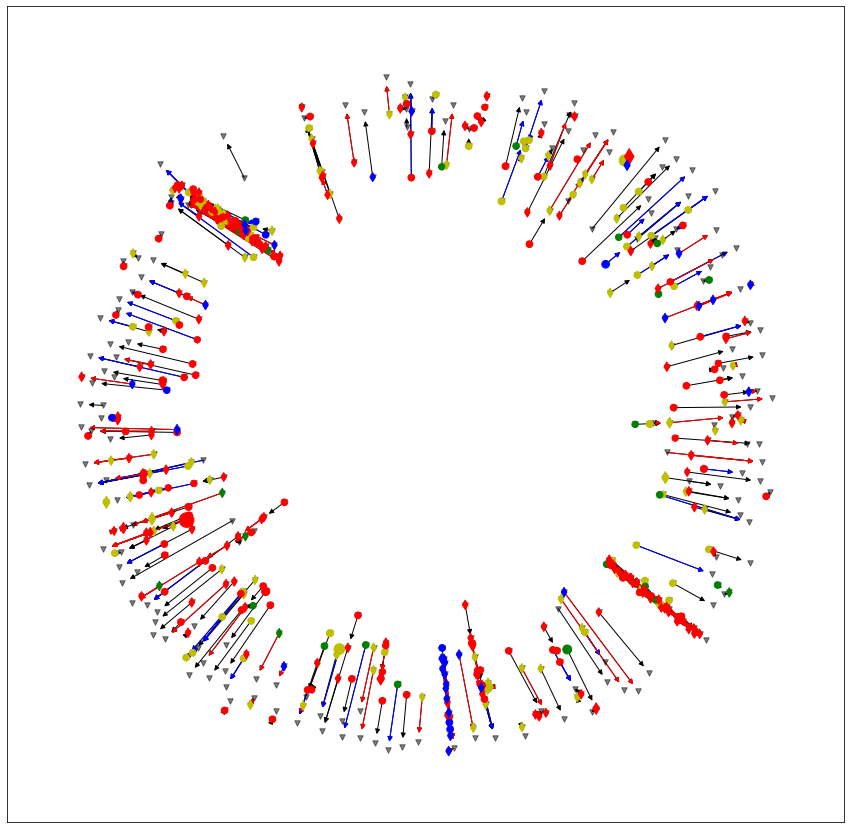

<Figure size 4500x4500 with 0 Axes>

In [0]:
Mar_data_full = n_data.loc[(n_data['confirmed_date'] >= '2020-03-01') & (n_data['confirmed_date'] < '2020-04-01')]
March_full = draw_month_graph(Mar_data_full,patient_full)
plt.rcParams['figure.figsize']=(15,15)   
plt.figure(3, figsize=(15,15), dpi=300)

### April Diagram

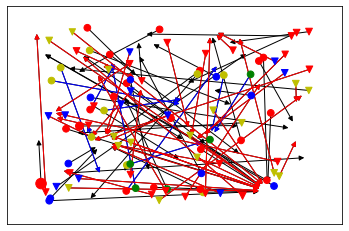

In [0]:
Apr_data_first = n_data.loc[(n_data['confirmed_date'] >= '2020-04-01') & (n_data['confirmed_date'] < '2020-04-11')]
Apr_first = draw_month_graph(Apr_data_first,patient_full)

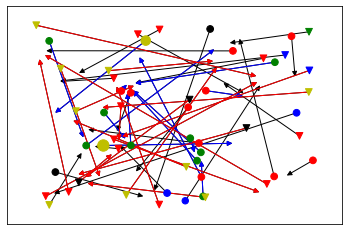

In [0]:
Apr_data_second = n_data.loc[(n_data['confirmed_date'] >= '2020-04-11') & (n_data['confirmed_date'] < '2020-04-21')]
Apr_second = draw_month_graph(Apr_data_second,patient_full)

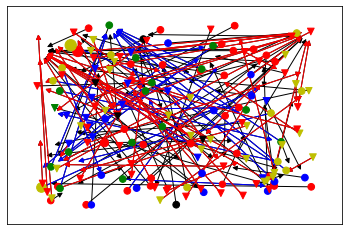

In [0]:
Apr_data_full = n_data.loc[(n_data['confirmed_date'] >= '2020-04-01') & (n_data['confirmed_date'] < '2020-05-01')]
Apr_full = draw_month_graph(Apr_data_full, patient_full)

### May Diagram

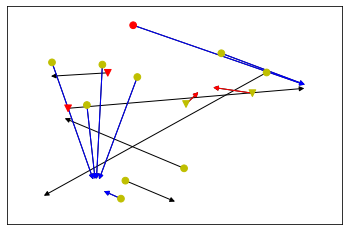

In [0]:
May_data_full = n_data.loc[(n_data['confirmed_date'] >= '2020-05-01') & (n_data['confirmed_date'] < '2020-06-01')]
May_full = draw_month_graph(May_data_full, patient_full)

## Analysis

In [0]:
#Are there any patterns in those network? For example, the transmission between male is more or between female or something else?
#Which months has higher infections rate?
#which age group has the most pateints?
#any other interesting finding

### Monthly Analysis

In [0]:
# Number of patients by months
time_data = n_data
time_data.index = pd.to_datetime(n_data['confirmed_date'], format='%Y-%M-%d')
time_data['confirmed_date'].groupby(pd.Grouper(freq='M')).agg(['min', 'max', 'count'])

,min,max,count
confirmed_date,,,
2020-01-31,2020-01-30,2020-01-31,4
2020-02-29,2020-02-02,2020-02-29,205
2020-03-31,2020-03-01,2020-03-31,461
2020-04-30,2020-04-01,2020-04-27,152
2020-05-31,2020-05-07,2020-05-12,14


March was by far the worst month for infections

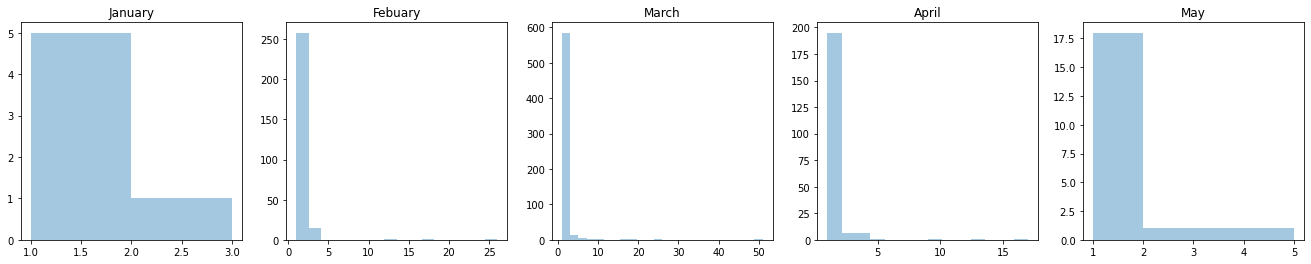

In [0]:
# Check degree of each graph, then plot pmf and log-log scale pmf graph, to see what kind of distribution occured. 
# You can take a look on the code of lecture 4, or textbook cheapter 4
fig, axs = plt.subplots(ncols=5, figsize=(23, 4))
for i, (G, name) in enumerate(zip([Jan, Feb_full, March_full, Apr_full, May_full], ['January', 'Febuary', 'March', 'April', 'May'])):
  sns.distplot([d for n, d in G.degree()], kde=False, ax=axs[i]).set_title(name);

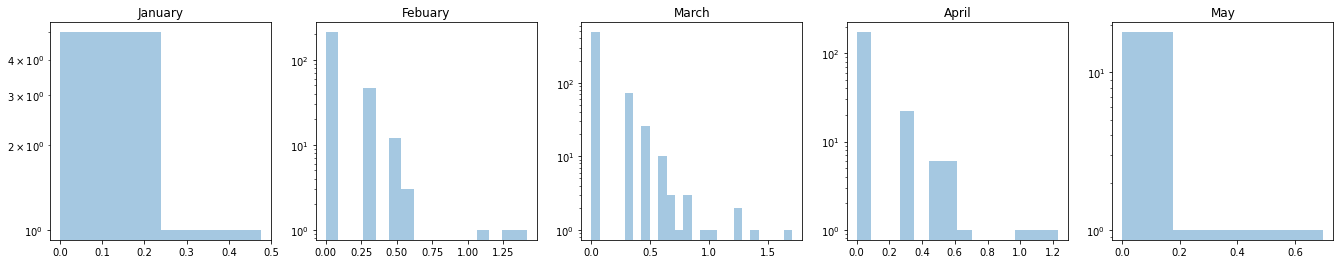

In [0]:
# log-log degree distribution
fig, axs = plt.subplots(ncols=5, figsize=(23, 4))
for i, (G, name) in enumerate(zip([Jan, Feb_full, March_full, Apr_full, May_full], ['January', 'Febuary', 'March', 'April', 'May'])):
  sns.distplot([np.log10(d) for n, d in G.degree()], kde=False, ax=axs[i], hist_kws={'log': True}).set_title(name);

Seems to most closely match a Power law distribution

In [0]:
data_full = n_data.loc[(n_data['confirmed_date'] >= '2019') & (n_data['confirmed_date'] < '2021')]
G = draw_month_graph(data_full, patient_full)

TypeError: ignored

### Sex-based Analysis

In [0]:
n_data.groupby('sex').agg('count')

,Age_group,infected_by,contact_number,confirmed_date,city
sex,,,,,
female,473,485,485,485,485
male,340,351,351,351,351


Way more cases in females

### Age-based Analysis

In [0]:
n_data.groupby('age').agg('count')